## Data quality check / cleaning / preparation 

### Data quality check and cleaning
*By Joseph Prette*

1. The following section briefly explores the basics of the data
2. Removes row of missing values from end of dataframe
3. Explores columns which feature a rare category that may be of high influence

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools
import time
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Import file
rev_train = pd.read_csv('../Project Code/Data/expanded', delimiter='\t', header=None, names=['characteristics'])
rev_train = rev_train['characteristics'].str.split(',', expand=True)
rev_train = rev_train.drop(range(7)).reset_index(drop=True)

# Implement descriptive column names
column_names = ['edibility','cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat']
rev_train.columns = column_names
rev_train.head()

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [2]:
# Get shape of data
original_shape = rev_train.shape
print('The dataset has {} entries, with {} characteristics'.format(original_shape[0], original_shape[1]))

pd.set_option('display.max_columns', None)
rev_train.describe()

The dataset has 8417 entries, with 23 characteristics


,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
count,8417,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416
unique,3,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS
freq,4488,3796,3268,2320,5040,3808,8200,6824,5880,1728,4864,3800,5316,5076,4744,4640,8416,8216,7768,3968,2424,4064,3160


In [3]:
# Find number of missing values in each column
rev_train.isna().sum()

edibility                   0
cap_shape                   1
cap_surface                 1
cap_color                   1
bruises                     1
odor                        1
gill_attachment             1
gill_spacing                1
gill_size                   1
gill_color                  1
stalk_shape                 1
stalk_root                  1
stalk_surface_above_ring    1
stalk_surface_below_ring    1
stalk_color_above_ring      1
stalk_color_below_ring      1
veil_type                   1
veil_color                  1
ring_number                 1
ring_type                   1
spore_print_color           1
population                  1
habitat                     1
dtype: int64

In [4]:
# Show rows with missing columns
rev_train[rev_train.isnull().any(axis=1)]

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
8416,----------------------------------------------...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [5]:
# drop rows (in this case just the one row) containing any NA or None values
rev_train = rev_train.drop(rev_train[rev_train.isnull().any(axis=1)].index)

# show shape has changed:
updated_shape = rev_train.shape
print('The dataset has {} entries, with {} characteristics'.format(updated_shape[0], updated_shape[1]))
print('{} row(s) were removed'.format(original_shape[0] - updated_shape[0]))
print('{} column(s) were removed'.format(original_shape[1] - updated_shape[1]))

The dataset has 8416 entries, with 23 characteristics
1 row(s) were removed
0 column(s) were removed


In [6]:
# view the updated description of the data
rev_train.describe()

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
count,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS
freq,4488,3796,3268,2320,5040,3808,8200,6824,5880,1728,4864,3800,5316,5076,4744,4640,8416,8216,7768,3968,2424,4064,3160


In [7]:
# rare is commonly defined as < .1%, using .1% as threshold for values.
col_with_rare = list()
for col_name in rev_train.columns:
    for n in range(len(rev_train[col_name].value_counts())):
        if rev_train[col_name].value_counts()[n] / rev_train.shape[0] < 0.001:
            col_with_rare.append(col_name)
            #print(train[col_name].value_counts())
            #print()
            break;

col_with_rare

['cap_shape', 'cap_surface', 'stalk_color_above_ring', 'veil_color']

### Data Preparation
*By Lucy Han & Jackson Bremen*

1. Verified data is not severely imbalanced
2. Implemented dummy variable for edibility
3. Split given data into a training (85%) and test (15%) dataset

In [8]:
# read in the data
full_data = pd.read_csv('../Project Code/Data/expanded_clean.csv', index_col=0)

# rename the 'class' column to 'poisonous' for clarity
# and convert to a binary variable
full_data.rename(columns={'class':'poisonous'}, inplace=True)
full_data['poisonous'] = full_data['poisonous'] == 'POISONOUS'

# Replace all '-' characters in the headers with '_'
full_data.columns = full_data.columns.str.replace('-', '_')

# Remove a ? from the headers
full_data.columns = full_data.columns.str.replace('?', '')

full_data.head()

/var/folders/r0/8t9nmvg139bbjln3b2z3p_nw0000gn/T/ipykernel_77387/2332688028.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  full_data.columns = full_data.columns.str.replace('?', '')


,poisonous,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,False,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [9]:
# Split the data into training and test sets
train, test = train_test_split(full_data, test_size=0.15, random_state=100)

### Exploratory data analysis
*By Chanel Sun and Jackson Bremen*

1. Discovered `odor` to be very strong predictor for edibility, with certain odors having all or none edible, and just one with ~97% edible
2. Decided to build model using only `odor`, but acknowledge the limitations and will build second without `odor`
3. `veil-type` has only one level, 'PARTIAL', meaning it will have no effect on edibility, so this variable will not be used.
4. We observed that the barplots of `stalk_surface_above_ring` and `stalk_surface_below_ring`, as well as `stalk_color_above_ring` and `stalk_color_below_ring`, showed a high degree of similarity. One from each will be dropped using SelectKBest.

In [10]:
def var_transform (data):
    data['edibility']=data['edibility'].apply(lambda x: 1 if x=='EDIBLE' else 0)
    return data
var_transform(rev_train).head()

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


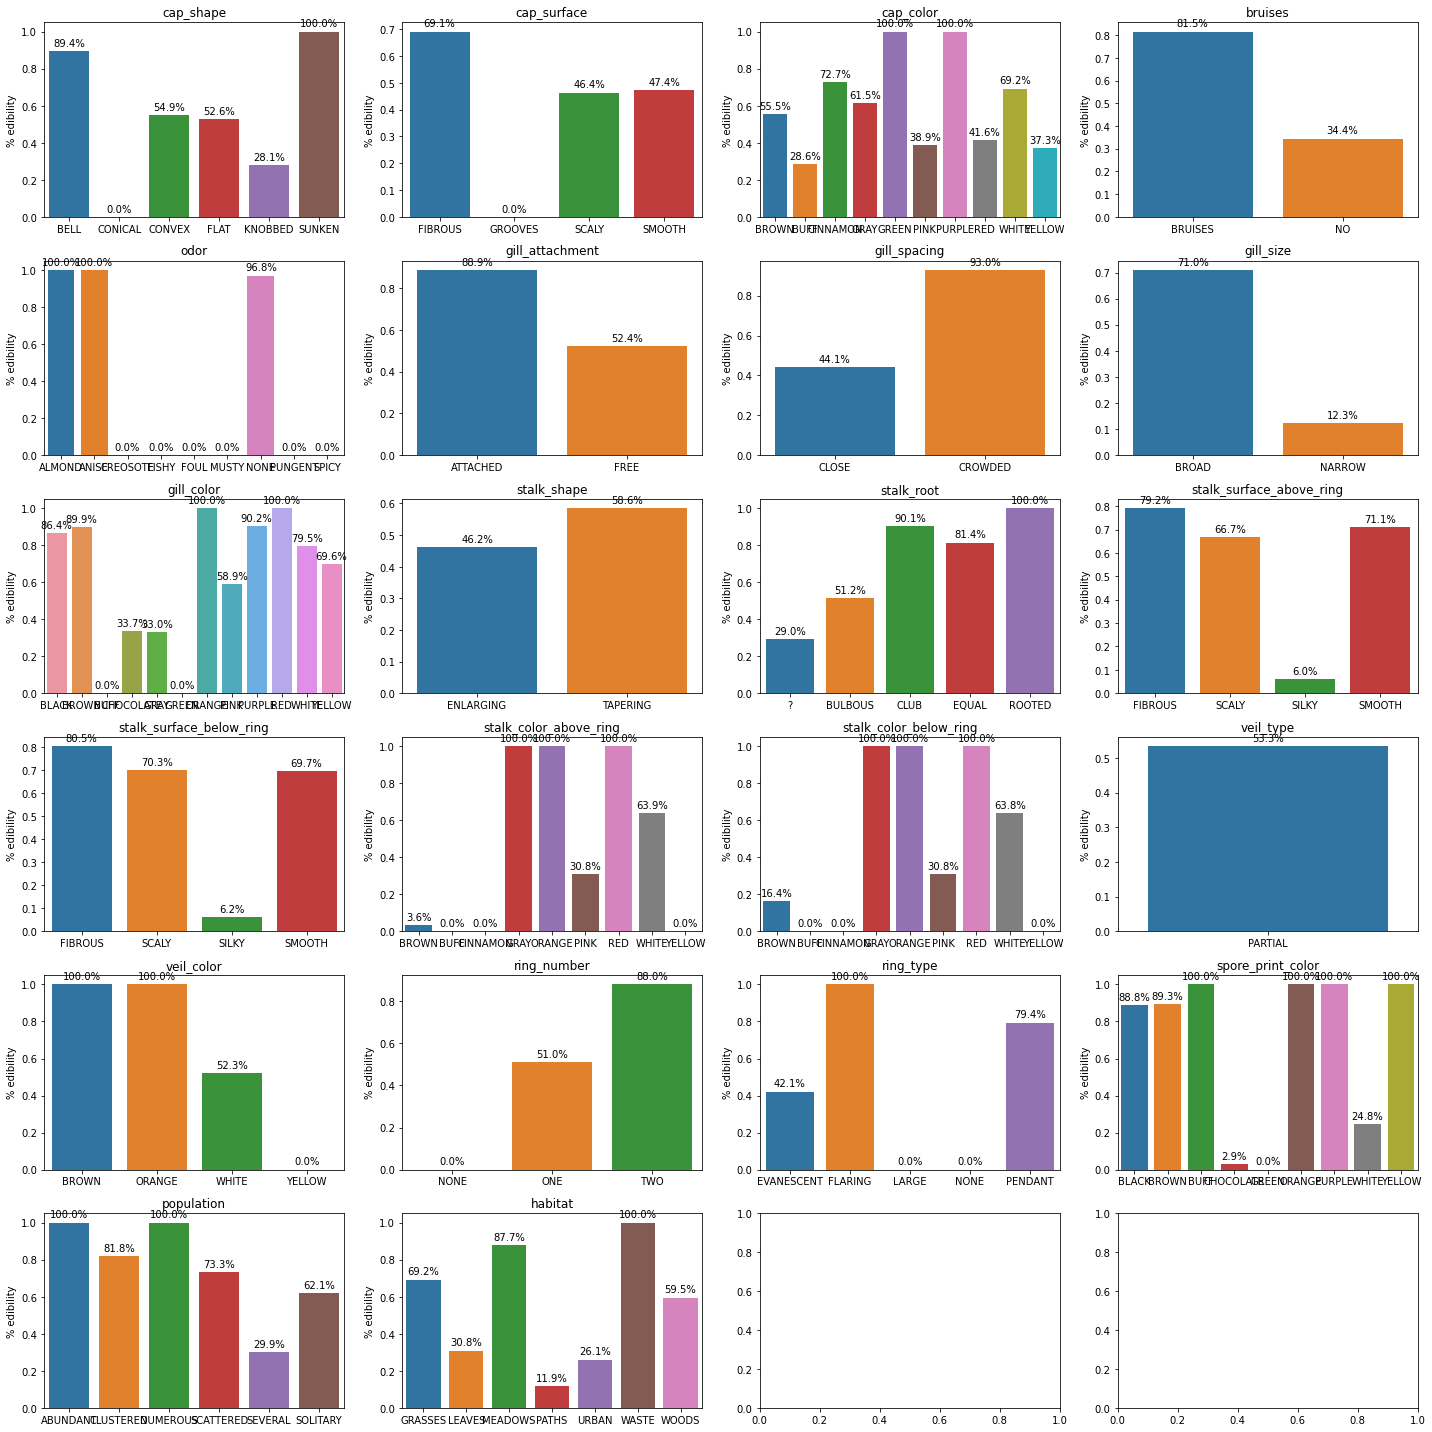

In [11]:
# Create list of the prediction variables; all but the first column (edibility)
predictors = rev_train.columns[1:]

# Display the edibility of each cateogry of each prediction variable
fig, axs = plt.subplots(6, 4, figsize=(20, 20))
for i, predictor in enumerate(predictors):
    row = i // 4
    col = i % 4
    data = rev_train[['edibility', predictor]].groupby([predictor], as_index=False).mean()
    sns.barplot(x=predictor, y='edibility', data=data, ax=axs[row, col])
    axs[row, col].set_title(f'{predictor}')
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel('% edibility')
    for rect in axs[row, col].patches:
        height = rect.get_height()
        axs[row, col].annotate(f'{height:.1%}', xy=(rect.get_x() + rect.get_width() / 2, height), 
                               xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [12]:
# Make temporary dataset without unnecessary columns, save response variable column as Y
X = rev_train.drop(['edibility', 'veil_type', 'stalk_surface_below_ring', 'stalk_color_below_ring'], axis=1)
Y = rev_train['edibility']

## Developing the model

### Model Constrution

#### General Functions

In [13]:
#Function to compute confusion matrix and prediction accuracy
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))
def plot_precision_vs_threshold(precision, recall, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylabel("Precision/Recall")

#### Model 1: `odor`
*By Chanel Sun and Lucy Han*

In [14]:
# Create a model to predict poisonous using odor

train_1 = train.copy()

# If odor is equal to ALMOND, ANISE, or NONE, set it to 0, else 1
train_1['odor'] = train_1['odor'].apply(lambda x: 0 if x in ['ALMOND', 'ANISE', 'NONE'] else 1).astype(int)
train_1['poisonous'] = train_1['poisonous'].astype(int)

# Train a linear regression model
model_1 = smf.logit(formula='poisonous~odor', data=train_1).fit()
model_1.summary()

         Current function value: 0.065608
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              poisonous   No. Observations:                 7153
Model:                          Logit   Df Residuals:                     7151
Method:                           MLE   Df Model:                            1
Date:                Sun, 12 Mar 2023   Pseudo R-squ.:                  0.9050
Time:                        18:13:32   Log-Likelihood:                -469.30
converged:                      False   LL-Null:                       -4941.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6334      0.101    -36.042      0.000      -3.831      -3.436
odor          29.9791   9253.047      0.003      0.997   -1.81e+04    1.82e+04
==============================================================================

Possibly complete quasi-separation: A fraction 0.45 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Classification accuracy = 98.5%
Precision = 100.0%
TPR or Recall = 96.8%
FNR = 3.2%
FPR = 0.0%
ROC-AUC = 98.4%


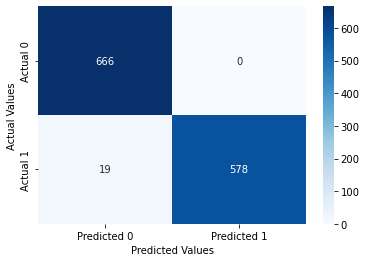

In [15]:
# Print the confusion matrix for test_1
test_1 = test.copy()
test_1['odor'] = test_1['odor'].apply(lambda x: 0 if x in ['ALMOND', 'ANISE', 'NONE'] else 1).astype(int)
test_1['poisonous'] = test_1['poisonous'].astype(int)

confusion_matrix_data(test_1[['odor']], test_1['poisonous'], model_1)

#### Model 2: Complex Model
*By Jackson Bremen*

In [16]:
train_2 = train.copy()

train_2['poisonous'] = train_2['poisonous'].astype(int)

columns_to_use = ['cap_shape', 'cap_surface', 'cap_color', 'bruises',
                  'gill_attachment', 'gill_spacing', 'gill_size', 'stalk_color_above_ring']

formula = 'poisonous ~ ' + ' + '.join(columns_to_use)

print(formula)

# Train a linear regression model
model_2 = smf.logit(formula=formula, data=train_2).fit()
model_2.summary()

poisonous ~ cap_shape + cap_surface + cap_color + bruises + gill_attachment + gill_spacing + gill_size + stalk_color_above_ring
         Current function value: 0.134357
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              poisonous   No. Observations:                 7153
Model:                          Logit   Df Residuals:                     7123
Method:                           MLE   Df Model:                           29
Date:                Sun, 12 Mar 2023   Pseudo R-squ.:                  0.8055
Time:                        18:13:32   Log-Likelihood:                -961.06
converged:                      False   LL-Null:                       -4941.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -2.5900   4.47e+06  -5.79e-07      1.000   -8.76e+06    8.76e+06
cap_shape[T.CONICAL]                  28.5980    1.7e+05      0.000      1.000   -3.32e+05    3.32e+05
cap_shape[T.CONVEX]                    1.2061      0.242      4.976      0.000       0.731       1.681
cap_shape[T.FLAT]                      1.5940      0.251      6.350      0.000       1.102       2.086
cap_shape[T.KNOBBED]                   0.3657      0.409      0.895      0.371      -0.436       1.167
cap_shape[T.SUNKEN]                  -20.3935    950.638     -0.021      0.983   -1883.609    1842.822
cap_surface[T.GROOVES]                25.9307   1.74e+04      0.001      0.999    -3.4e+04    3.41e+04
cap_surface[T.SCALY]                   1.2492      0.201      6.221      0.000       0.856       1.643
cap_surface[T.SMOOTH]                  3.6315      0.247     14.709      0.000       3.148       4.115
cap_color[T.BUFF]                      5.9038      0.404     14.599      0.000       5.111       6.696
cap_color[T.CINNAMON]                -10.2396    191.569     -0.053      0.957    -385.707     365.228
cap_color[T.GRAY]                      3.0607      0.300     10.206      0.000       2.473       3.649
cap_color[T.GREEN]                   -24.2186   7175.505     -0.003      0.997   -1.41e+04     1.4e+04
cap_color[T.PINK]                      4.9986      0.394     12.698      0.000       4.227       5.770
cap_color[T.PURPLE]                  -48.3165   1.32e+09  -3.67e-08      1.000   -2.58e+09    2.58e+09
cap_color[T.RED]                       0.5070      0.374      1.354      0.176      -0.227       1.241
cap_color[T.WHITE]                     3.3804      0.299     11.288      0.000       2.793       3.967
cap_color[T.YELLOW]                    2.6737      0.302      8.854      0.000       2.082       3.266
bruises[T.NO]                          3.6642      0.192     19.041      0.000       3.287       4.041
gill_attachment[T.FREE]               -2.2677   4.47e+06  -5.07e-07      1.000   -8.76e+06    8.76e+06
gill_spacing[T.CROWDED]               -6.5551      0.260    -25.257      0.000      -7.064      -6.046
gill_size[T.NARROW]                    5.8011      0.262     22.157      0.000       5.288       6.314
stalk_color_above_ring[T.BUFF]        18.9084   3853.728      0.005      0.996   -7534.260    7572.077
stalk_color_above_ring[T.CINNAMON]    41.2470   4.25e+06   9.71e-06      1.000   -8.33e+06    8.33e+06
stalk_color_above_ring[T.GRAY]       -22.3081   4213.557     -0.005      0.996   -8280.729    8236.112
stalk_color_above_ring[T.ORANGE]     -30.0542   4.47e+06  -6.72e-06      1.000   -8.76e+06    8.76e+06
stalk_color_above_ring[T.PINK]        -1.5333      0.328     -4.679      0.000      -2.176      -0.891
stalk_color_above_ring[T.RED]        -61.0719    2.3e+11  -2.65e-10      1.000   -4.51e+11    4.51e+11
stalk_color_above_ring[T.WHITE]       -3.5346   

Classification accuracy = 96.7%
Precision = 95.4%
TPR or Recall = 97.7%
FNR = 2.3%
FPR = 4.2%
ROC-AUC = 98.8%


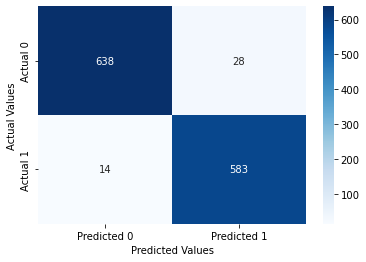

In [17]:
# Test the model on the test set
test_2 = test.copy()
test_2['poisonous'] = test_2['poisonous'].astype(int)

confusion_matrix_data(test_2[columns_to_use], test_2['poisonous'], model_2, cutoff=0.4)

When the threshold is 0.98047
the precision is 0.96576
the recall is 0.95677
maximizing_threshold is 0.98047


<AxesSubplot:xlabel='Threshold', ylabel='Precision/Recall'>

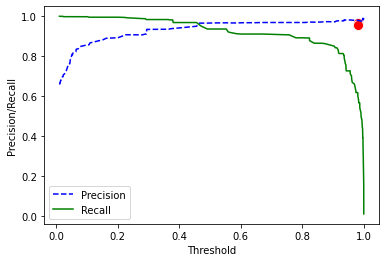

In [18]:
# Find the optimal cutoff
y = train_2['poisonous']
y_predict = model_2.predict(train_2)
p, r, prc_thresholds = precision_recall_curve(train_2['poisonous'], model_2.predict(train_2))

fpr, tpr, thresholds = roc_curve(y, y_predict)

plot_precision_vs_threshold(p, r, prc_thresholds)

maximizing_threshold = thresholds[np.argmax(p[:-1] * r[:-1])]

print(f"When the threshold is {round(maximizing_threshold, 5)}")
print(f"the precision is {round(p[np.argmin(np.abs(thresholds - maximizing_threshold))], 5)}")
print(f"the recall is {round(r[np.argmin(np.abs(thresholds - maximizing_threshold))], 5)}")
print(f"maximizing_threshold is {round(maximizing_threshold, 5)}")

# Find the point in precision where threshold is closest to maximizing_threshold

y0 = p[np.argmin(np.abs(thresholds - maximizing_threshold))]
y1 = r[np.argmin(np.abs(thresholds - maximizing_threshold))]

sns.scatterplot(x=[maximizing_threshold], y=[y0], color='red', s=100)
sns.scatterplot(x=[maximizing_threshold], y=[y1], color='red', s=100)

### Model Experimentation & Subset Selection

*By Lucy Han & Chanel Sun*

In [19]:
# one-hot encoding
X = pd.get_dummies(X, columns=['cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring',  
                'stalk_color_above_ring', 'veil_color', 'ring_number', 'ring_type', 
                'spore_print_color', 'population','habitat'], drop_first=True)
X.shape

(8416, 84)

In [20]:
# Get variable inflation factors
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Predictor"] = X.columns
vif_inf = vif[np.isinf(vif['VIF Factor'])]
# printing those with VIF value of inf
vif_inf

/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,Predictor
19,inf,odor_CREOSOTE
20,inf,odor_FISHY
21,inf,odor_FOUL
22,inf,odor_MUSTY
23,inf,odor_NONE
24,inf,odor_PUNGENT
25,inf,odor_SPICY
28,inf,gill_size_NARROW
30,inf,gill_color_BUFF
40,inf,stalk_shape_TAPERING


In [21]:
vif_inf.shape

(23, 2)

In [22]:
# create dummy variables for each categorical variable
data = rev_train.copy()
cat_vars = list(data.select_dtypes(include=['object']).columns)
dummy_vars = pd.get_dummies(data[cat_vars], prefix=cat_vars)
# concatenate the dummy variables with the original dataset
data = pd.concat([data.drop(cat_vars, axis=1), dummy_vars], axis=1)

print(data.shape) #we obtained 117 predictors and 1 response variable

(8416, 118)


In [23]:
data.head(2)

,edibility,cap_shape_BELL,cap_shape_CONICAL,cap_shape_CONVEX,cap_shape_FLAT,cap_shape_KNOBBED,cap_shape_SUNKEN,cap_surface_FIBROUS,cap_surface_GROOVES,cap_surface_SCALY,cap_surface_SMOOTH,cap_color_BROWN,cap_color_BUFF,cap_color_CINNAMON,cap_color_GRAY,cap_color_GREEN,cap_color_PINK,cap_color_PURPLE,cap_color_RED,cap_color_WHITE,cap_color_YELLOW,bruises_BRUISES,bruises_NO,odor_ALMOND,odor_ANISE,odor_CREOSOTE,odor_FISHY,odor_FOUL,odor_MUSTY,odor_NONE,odor_PUNGENT,odor_SPICY,gill_attachment_ATTACHED,gill_attachment_FREE,gill_spacing_CLOSE,gill_spacing_CROWDED,gill_size_BROAD,gill_size_NARROW,gill_color_BLACK,gill_color_BROWN,gill_color_BUFF,gill_color_CHOCOLATE,gill_color_GRAY,gill_color_GREEN,gill_color_ORANGE,gill_color_PINK,gill_color_PURPLE,gill_color_RED,gill_color_WHITE,gill_color_YELLOW,stalk_shape_ENLARGING,stalk_shape_TAPERING,stalk_root_?,stalk_root_BULBOUS,stalk_root_CLUB,stalk_root_EQUAL,stalk_root_ROOTED,stalk_surface_above_ring_FIBROUS,stalk_surface_above_ring_SCALY,stalk_surface_above_ring_SILKY,stalk_surface_above_ring_SMOOTH,stalk_surface_below_ring_FIBROUS,stalk_surface_below_ring_SCALY,stalk_surface_below_ring_SILKY,stalk_surface_below_ring_SMOOTH,stalk_color_above_ring_BROWN,stalk_color_above_ring_BUFF,stalk_color_above_ring_CINNAMON,stalk_color_above_ring_GRAY,stalk_color_above_ring_ORANGE,stalk_color_above_ring_PINK,stalk_color_above_ring_RED,stalk_color_above_ring_WHITE,stalk_color_above_ring_YELLOW,stalk_color_below_ring_BROWN,stalk_color_below_ring_BUFF,stalk_color_below_ring_CINNAMON,stalk_color_below_ring_GRAY,stalk_color_below_ring_ORANGE,stalk_color_below_ring_PINK,stalk_color_below_ring_RED,stalk_color_below_ring_WHITE,stalk_color_below_ring_YELLOW,veil_type_PARTIAL,veil_color_BROWN,veil_color_ORANGE,veil_color_WHITE,veil_color_YELLOW,ring_number_NONE,ring_number_ONE,ring_number_TWO,ring_type_EVANESCENT,ring_type_FLARING,ring_type_LARGE,ring_type_NONE,ring_type_PENDANT,spore_print_color_BLACK,spore_print_color_BROWN,spore_print_color_BUFF,spore_print_color_CHOCOLATE,spore_print_color_GREEN,spore_print_color_ORANGE,spore_print_color_PURPLE,spore_print_color_WHITE,spore_print_color_YELLOW,population_ABUNDANT,population_CLUSTERED,population_NUMEROUS,population_SCATTERED,population_SEVERAL,population_SOLITARY,habitat_GRASSES,habitat_LEAVES,habitat_MEADOWS,habitat_PATHS,habitat_URBAN,habitat_WASTE,habitat_WOODS
0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [24]:
from sklearn.model_selection import train_test_split
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['edibility'], axis=1),
    data['edibility'],
    test_size=0.15,
    random_state=23)

X_train.shape, X_test.shape

((7153, 117), (1263, 117))

In [25]:
cutoff=0.5
def fit_linear_reg(X,Y):
    # Fit linear regression model and return classification accuracy
    model_k = linear_model.LinearRegression()
    model_k.fit(X, Y)

    # Predicted vs Actual
    actual_values = Y
    pred_values = model_k.predict(X)
    bins = np.array([0, cutoff, 1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]

    # Calculate the accuracy
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    fpr = (cm[0,1]) / (cm[0,0] + cm[0,1])

    #print("Classification accuracy = {:.1%}".format(accuracy))
    #print("FPR = {:.1%}".format(fpr))

    return accuracy, fpr

In [26]:
#forward selection
k = 117

remaining_features = list(X_train.columns.values)
features = []
accuracy_list, fpr_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_accuracy = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            accuracy = fit_linear_reg(X_train[list(combo) + features],y_train)   #Store temp result 

            if accuracy[0] < best_accuracy:
                best_accuracy = accuracy[0]
                best_fpr = accuracy[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    accuracy_list.append(best_accuracy)
    fpr_list.append(best_fpr)
    features_list[i] = features.copy()

In [29]:
df = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'accuracy':accuracy_list, 'fpr': fpr_list})], axis=1, join='inner')
df['numb_features'] = df.index
df.tail(10)

,features,accuracy,fpr,numb_features
108,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.998305,0.003642,108
109,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.998109,0.004111,109
110,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.998064,0.004132,110
111,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.998540,0.003170,111
112,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.998572,0.003110,112
113,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.998585,0.003085,113
114,"[stalk_color_above_ring_GRAY, stalk_color_belo...",1.000000,0.000000,114
115,"[stalk_color_above_ring_GRAY, stalk_color_belo...",1.000000,0.000000,115
116,"[stalk_color_above_ring_GRAY, stalk_color_belo...",1.000000,0.000000,116
117,"[stalk_color_above_ring_GRAY, stalk_color_belo...",1.000000,0.000000,117


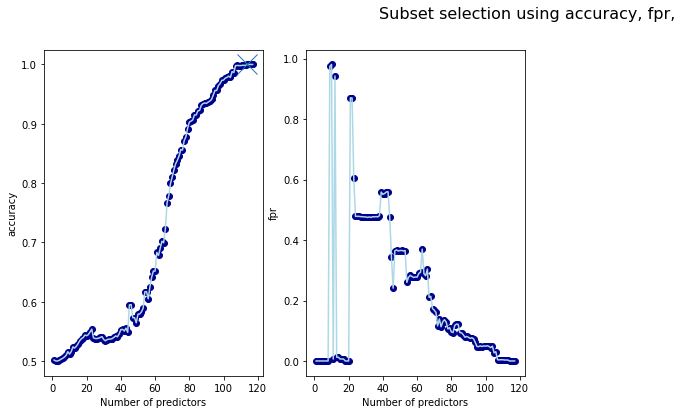

In [30]:
variables = ['accuracy','fpr']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df['numb_features'],df[v], color = 'lightblue')
    ax.scatter(df['numb_features'],df[v], color = 'darkblue')
    if v == 'accuracy':
        ax.plot(df[v].idxmax(),df[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df[v].idxmin(),df[v].min(), markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using accuracy, fpr, ', fontsize = 16)
plt.show()

# Model using SFS forward selection

In [ ]:
!pip install mlxtend

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs_forward = SFS(LogisticRegression(), 
                  k_features=10, 
                  forward=True, 
                  floating=False, 
                  verbose=2,
                  scoring='accuracy',
                  cv=5)
sfs_forward = sfs_forward.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:    3.3s finished

[2023-03-12 21:34:09] Features: 1/10 -- score: 0.8909549290681366[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    4.4s finished

[2023-03-12 21:34:13] Features: 2/10 -- score: 0.9458968983497286[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    4.9s finished

[2023-03-12 21:34:18] Features: 3/10 -- score: 0.9691043966515664[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [95]:
selected_features = X_train.columns[list(sfs_forward.k_feature_idx_)]
selected_features

Index(['odor_ALMOND', 'odor_ANISE', 'odor_FOUL', 'odor_NONE',
       'gill_size_BROAD', 'stalk_root_CLUB', 'stalk_root_ROOTED',
       'stalk_surface_below_ring_SCALY', 'spore_print_color_GREEN',
       'spore_print_color_PURPLE'],
      dtype='object')

In [96]:
# Evaluate the model using the selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[selected_features], y_train)
y_pred = logreg.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)
# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)
print('Recall:', recall)

Accuracy: 0.997624703087886
False positive rate: 0.005145797598627788
Recall: 1.0


We have a model that is theoretically perfect, but for the sake of the safety and well-being of our stakeholders, we will make our best attempt to create a model that does not include the feature 'odor'.

# Model using SFS forward selection (without odor)

In [97]:
# label encoding 
data_encoded = rev_train.drop(['odor','veil_type'], axis=1)
from sklearn.preprocessing import LabelEncoder 
label = LabelEncoder()
for col in data_encoded.columns:
    if data_encoded[col].dtypes =='O':
        data_encoded[col]=label.fit_transform(data_encoded[col])
data_encoded.head()

,edibility,cap_shape,cap_surface,cap_color,bruises,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,2,3,8,0,1,1,1,10,1,1,3,3,7,7,2,1,4,6,4,6
1,1,2,3,8,0,1,1,1,10,1,1,3,3,7,7,2,1,4,1,4,6
2,1,2,3,8,0,1,1,1,7,1,1,3,3,7,7,2,1,4,6,4,6
3,1,2,3,8,0,1,1,1,7,1,1,3,3,7,7,2,1,4,1,4,6
4,1,2,3,8,0,1,1,1,1,1,1,3,3,7,7,2,1,4,6,4,6


In [98]:
X = data_encoded.drop('edibility',axis=1)
y = data_encoded['edibility']

In [99]:
#Select KBest
from sklearn.feature_selection import SelectKBest, chi2
features_kbest = SelectKBest(chi2, k=12).fit(X,y)
feature_names = features_kbest.get_feature_names_out()
feature_names

array(['cap_surface', 'cap_color', 'bruises', 'gill_spacing', 'gill_size',
       'gill_color', 'stalk_root', 'stalk_color_above_ring',
       'stalk_color_below_ring', 'ring_type', 'spore_print_color',
       'population'], dtype=object)

In [100]:
X_filtered = data_encoded[feature_names]
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered,
    y,
    test_size=0.15,
    random_state=23)

X_train.shape, X_test.shape

((7153, 12), (1263, 12))

In [101]:
sfs_forward = SFS(LogisticRegression(), 
                  k_features=10, 
                  forward=True, 
                  floating=False, 
                  verbose=2,
                  scoring='accuracy',
                  cv=5)
sfs_forward = sfs_forward.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished

[2023-03-12 21:36:40] Features: 1/10 -- score: 0.7616404001309661[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished

[2023-03-12 21:36:40] Features: 2/10 -- score: 0.8671903358695812[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished

[2023-03-12 21:36:41] Features: 3/10 -- score: 0.8671903358695812[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [102]:
selected_features = X_train.columns[list(sfs_forward.k_feature_idx_)]
selected_features

Index(['cap_color', 'bruises', 'gill_spacing', 'gill_size', 'gill_color',
       'stalk_root', 'stalk_color_above_ring', 'stalk_color_below_ring',
       'ring_type', 'population'],
      dtype='object')

In [103]:
# Evaluate the model using the selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[selected_features], y_train)
y_pred = logreg.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)
# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)
print('Recall:', recall)

Accuracy: 0.9176563737133808
False positive rate: 0.10806174957118353
Recall: 0.9397058823529412


/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


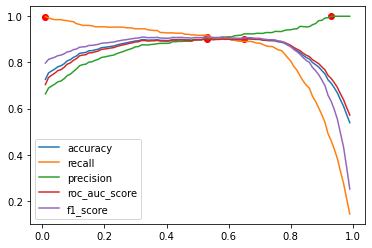

In [104]:
#tuning the threshold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, f1_score

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
data=[]
THRESHOLDS=np.arange(0.01,1,0.01)
for THRESHOLD in THRESHOLDS:
  preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
  data.append([accuracy_score(y_test, preds), recall_score(y_test, preds),
                    precision_score(y_test, preds), roc_auc_score(y_test, preds), f1_score(y_test, preds)])
  
df=pd.DataFrame(data=np.array(data).T, columns=THRESHOLDS,
              index=["accuracy", "recall", "precision", "roc_auc_score", 'f1_score']).T
#plot
fig, ax = plt.subplots()
for col in df.columns:
    df[col].plot(ax=ax, label=col)
    ax.scatter(df[col].idxmax(), df[col].max(), color='red')
ax.legend()
plt.show()

### Code fitting the final model

#### Model 1: `odor`

In [27]:
model_1 = smf.logit(formula = 'poisonous ~ odor', data=train_1).fit()

         Current function value: 0.065608
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Model 2: Complex Model 

In [28]:
formula = 'poisonous ~ cap_shape + cap_surface + cap_color + bruises + gill_attachment + gill_spacing + gill_size + stalk_color_above_ring'
model_2 = smf.logit(formula = formula, data = train_2).fit()

         Current function value: 0.134357
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
